In [2]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [3]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# do t-test
from scipy.stats import ttest_ind

from SSMuLA.de_simulations import DE_COLORS, DE_TYPES, DE_LEGEND_MAP
from SSMuLA.landscape_global import LIB_INFO_DICT
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE, LIB_COLORS
from SSMuLA.zs_analysis import (
    ZS_OPTS,
    ZS_COMB_OPTS,
    ZS_OPTS_LEGEND,
)
from SSMuLA.vis_summary import (
    ZS_OPTS_APPENDED,
    ZS_COLOR_MAP_APPENDED
)

%matplotlib inline

In [22]:
five_zs = {
    "none": PRESENTATION_PALETTE_SATURATE["gray"],
    "ed_score": PRESENTATION_PALETTE_SATURATE["orange"],
    "Triad_score": PRESENTATION_PALETTE_SATURATE["blue"],
    "ev_score": PRESENTATION_PALETTE_SATURATE["green"],
    "esm_score": PRESENTATION_PALETTE_SATURATE["purple"],
    "esmif_score": PRESENTATION_PALETTE_SATURATE["yellow"],
}

triad_colors = {
    "Triad-esm_score": PRESENTATION_PALETTE_SATURATE["purple"],
    "Triad-ev_score": PRESENTATION_PALETTE_SATURATE["green"],
    "Triad_score": PRESENTATION_PALETTE_SATURATE["blue"],
    "struc-comb_score": PRESENTATION_PALETTE_SATURATE["yellow"],
}


In [7]:
def get_mlde_avg_df(mlde_all, n_sample, n_top, n_mut_cutoff, zs, active_lib_list):
    avg_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
        & (mlde_all["n_sample"].isin(n_sample))
    ][["zs", "lib", "n_sample", "top_maxes", "if_truemaxs"]].groupby(["zs", "lib", "n_sample"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    # avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

In [15]:
def avg_lib(mlde_all, n_sample, ifzsoret, zsoret, active_lib_list):

    avg_mlde = mlde_all[
            (mlde_all["lib"].isin(active_lib_list))
            & (mlde_all[ifzsoret].isin(zsoret))
            # & (mlde_all["n_top"] == n_top)
            # & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
            & (mlde_all["n_sample"].isin(n_sample))
        ][[ifzsoret, "n_sample", "top_maxes_mean", "if_truemaxs_mean"]].groupby([ifzsoret, "n_sample"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    return avg_mlde

In [23]:
# ft only 12.5
def get_mlde_avg_sdf(mlde_all, n_top, n_mut_cutoff, zs, active_lib_list, ft_frac = 0.125):
    slice_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
    ]
    
    if zs != "none":
        lib_dfs = []
        for lib in active_lib_list:
            lib_df = slice_mlde[slice_mlde["lib"] == lib].copy()
            lib_df["ft_lib_size"] = lib_df["ft_lib"].map(
                {
                    numb: frac
                    for numb, frac in zip(
                        sorted(lib_df["ft_lib"].unique()), FTLIB_FRAC_LIST
                    )
                }
            )
            lib_dfs.append(lib_df[lib_df["ft_lib_size"] == ft_frac])
        slice_mlde = pd.concat(lib_dfs)

    avg_mlde = slice_mlde[["n_sample", "top_maxes", "if_truemaxs"]].groupby("n_sample").agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

In [25]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]
FTLIB_FRAC_LIST = [0.125, 0.25, 0.5, 1]
mlde_all = pd.read_csv("results/mlde/all_df_comb_onehot.csv")
de_all = pd.read_csv("results/de/DE-active/scale2max/all_landscape_de_summary.csv")
lib_stat  = pd.read_csv("results/corr_all/384/boosting|ridge-top96/merge_all.csv")
active_cutoff = 1
active_lib_list = lib_stat[lib_stat["percent_active"]>active_cutoff]["lib"].tolist()

In [31]:
mlde_color_list = ["yellow", "orange", "blue", "green", "purple", "red"]
more_colors = [PRESENTATION_PALETTE_SATURATE[c] for c in mlde_color_list] + list(ZS_COLOR_MAP_APPENDED.values())[5:9] + [PRESENTATION_PALETTE_SATURATE["brown"], PRESENTATION_PALETTE_SATURATE["light_orange"], PRESENTATION_PALETTE_SATURATE["gray"], PRESENTATION_PALETTE_SATURATE["light_gray"]]

In [9]:
dsdf_mlde_df = (
    get_mlde_avg_df(
        mlde_all,
        # n_sample=[96, 384],
        n_sample=N_SAMPLE_LIST,
        n_top=96,
        n_mut_cutoff="double",
        zs=ZS_OPTS,
        active_lib_list=active_lib_list,
    )
)

dsdf_mlde_df["ZS_ensemble"] = dsdf_mlde_df["zs_"].map(lambda x: "Edited distance +" if x in ZS_OPTS else "Simple")
dsdf_mlde_df


,zs_,lib_,n_sample_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
0,Triad_score,DHFR,24,0.700466,0.269840,0.026667,0.161376,Edited distance +
1,Triad_score,DHFR,48,0.714445,0.271671,0.066667,0.249861,Edited distance +
2,Triad_score,DHFR,96,0.724867,0.277914,0.150000,0.357668,Edited distance +
3,Triad_score,DHFR,192,0.731809,0.282670,0.233333,0.423659,Edited distance +
4,Triad_score,DHFR,288,0.734054,0.283979,0.256667,0.437524,Edited distance +
...,...,...,...,...,...,...,...,...
395,ev_score,TrpB4,384,0.839669,0.107946,0.246667,0.431791,Edited distance +
396,ev_score,TrpB4,480,0.832131,0.106495,0.220000,0.414938,Edited distance +
397,ev_score,TrpB4,576,0.820506,0.100546,0.173333,0.379168,Edited distance +
398,ev_score,TrpB4,960,0.813826,0.096606,0.156667,0.364094,Edited distance +


In [10]:
ds_mlde_df = (
    get_mlde_avg_df(
        mlde_all,
        # n_sample=[96, 384],
        n_sample=N_SAMPLE_LIST,
        n_top=96,
        n_mut_cutoff="double",
        zs=["none"],
        active_lib_list=active_lib_list,
    )
)
ds_mlde_df["ZS_ensemble"] = ds_mlde_df["zs_"].map(lambda x: "Edited distance +" if (x in ZS_OPTS and x != "ed_score") else "Edited distance")
ds_mlde_df["zs_"] = "ed_score"
ds_mlde_df

,zs_,lib_,n_sample_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
0,ed_score,DHFR,24,0.884260,0.071623,0.11,0.314466,Edited distance
1,ed_score,DHFR,48,0.923741,0.065058,0.17,0.377525,Edited distance
2,ed_score,DHFR,96,0.955333,0.059433,0.41,0.494311,Edited distance
3,ed_score,DHFR,192,0.987020,0.032284,0.68,0.468826,Edited distance
4,ed_score,DHFR,288,0.992195,0.024971,0.75,0.435194,Edited distance
...,...,...,...,...,...,...,...,...
95,ed_score,TrpB4,384,0.784341,0.082458,0.05,0.218492,Edited distance
96,ed_score,TrpB4,480,0.782512,0.068551,0.04,0.196946,Edited distance
97,ed_score,TrpB4,576,0.789196,0.069327,0.02,0.140705,Edited distance
98,ed_score,TrpB4,960,0.797172,0.064732,0.02,0.140705,Edited distance


In [11]:
full_mlde_df = get_mlde_avg_df(
    mlde_all,
    # n_sample=[96, 384],
    n_sample=N_SAMPLE_LIST,
    n_top=96,
    n_mut_cutoff="all",
    zs=["none"] + ZS_OPTS + ["Triad-esm_score", "Triad-ev_score","struc-comb_score"],
    active_lib_list=active_lib_list,
)

full_mlde_df["ZS_ensemble"] = full_mlde_df["zs_"].map(
    lambda x: "Random"
    if x == "none"
    else (
        "Triad"
        if x == "Triad_score"
        else (
            "Simple" if (x in ZS_OPTS + ["none"] and x != "Triad_score") else "Triad +"
        )
    )
)
full_mlde_df

,zs_,lib_,n_sample_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
0,Triad-esm_score,DHFR,24,0.889867,0.117004,0.120000,0.325504,Triad +
1,Triad-esm_score,DHFR,48,0.925544,0.066081,0.176667,0.382024,Triad +
2,Triad-esm_score,DHFR,96,0.941446,0.061664,0.223333,0.417176,Triad +
3,Triad-esm_score,DHFR,192,0.965083,0.050815,0.356667,0.479816,Triad +
4,Triad-esm_score,DHFR,288,0.970681,0.049387,0.453333,0.498649,Triad +
...,...,...,...,...,...,...,...,...
795,struc-comb_score,TrpB4,384,0.788251,0.116215,0.091667,0.288796,Triad +
796,struc-comb_score,TrpB4,480,0.786185,0.109811,0.063333,0.243968,Triad +
797,struc-comb_score,TrpB4,576,0.792464,0.112871,0.090000,0.286660,Triad +
798,struc-comb_score,TrpB4,960,0.800263,0.108684,0.083333,0.276847,Triad +


In [12]:
merge_ens = pd.concat([full_mlde_df, ds_mlde_df, dsdf_mlde_df])
merge_ens

,zs_,lib_,n_sample_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
0,Triad-esm_score,DHFR,24,0.889867,0.117004,0.120000,0.325504,Triad +
1,Triad-esm_score,DHFR,48,0.925544,0.066081,0.176667,0.382024,Triad +
2,Triad-esm_score,DHFR,96,0.941446,0.061664,0.223333,0.417176,Triad +
3,Triad-esm_score,DHFR,192,0.965083,0.050815,0.356667,0.479816,Triad +
4,Triad-esm_score,DHFR,288,0.970681,0.049387,0.453333,0.498649,Triad +
...,...,...,...,...,...,...,...,...
395,ev_score,TrpB4,384,0.839669,0.107946,0.246667,0.431791,Edited distance +
396,ev_score,TrpB4,480,0.832131,0.106495,0.220000,0.414938,Edited distance +
397,ev_score,TrpB4,576,0.820506,0.100546,0.173333,0.379168,Edited distance +
398,ev_score,TrpB4,960,0.813826,0.096606,0.156667,0.364094,Edited distance +


In [13]:
merge_no_ed = merge_ens[merge_ens["ZS_ensemble"].isin(["Simple", "Triad", "Random"])].copy()
merge_no_ed["color"] = merge_no_ed["zs_"].map(lambda x: five_zs[x])
merge_no_ed["Ensemble type"] = "No edited distance"
merge_no_ed["zs_"] = pd.Categorical(merge_no_ed['zs_'], categories=list(five_zs.keys()), ordered=True)
merge_no_ed = merge_no_ed.sort_values(by=['zs_',])


merge_w_df = merge_ens[
    merge_ens["ZS_ensemble"].isin(["Edited distance +", "Edited distance"])
].copy()
merge_w_df["color"] = merge_w_df["zs_"].map(lambda x: five_zs[x])
merge_w_df["Ensemble type"] = "With edited distance"
merge_w_df["zs_"] = pd.Categorical(merge_w_df['zs_'], categories=list(five_zs.keys()), ordered=True)
merge_w_df = merge_w_df.sort_values(by=['zs_',])


merge_no_td = merge_ens[
    merge_ens["ZS_ensemble"].isin(["Simple", "Edited distance", "Random"])
].copy()
merge_no_td["color"] = merge_no_td["zs_"].map(lambda x: five_zs[x])
merge_no_td["Ensemble type"] = "No Triad"
merge_no_td["zs_"] = pd.Categorical(merge_no_td['zs_'], categories=list(five_zs.keys()), ordered=True)
merge_no_td = merge_no_td.sort_values(by=['zs_',])


merge_w_td = pd.concat(
    [
        merge_ens[merge_ens["ZS_ensemble"].isin(["Triad", "Triad +"])],
        merge_ens[
            (merge_ens["ZS_ensemble"] == "Edited distance +")
            & (merge_ens["zs_"] == "Triad_score")
        ],
    ]
).copy()
merge_w_td["color"] = merge_w_td["zs_"].map(lambda x: triad_colors[x])
merge_w_td["Ensemble type"] = "With Triad"
merge_w_td["zs_"] = pd.Categorical(merge_w_td['zs_'], categories=list(triad_colors.keys()), ordered=True)
merge_w_td = merge_w_td.sort_values(by=['zs_',])


all_slice_merge = pd.concat([merge_no_ed, merge_w_df, merge_no_td, merge_w_td])
all_slice_merge = all_slice_merge.rename(columns={"zs_": "zs", "lib_": "lib", "n_sample_": "n_sample"})
all_slice_merge

,zs,lib,n_sample,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble,color,Ensemble type
699,none,TrpB4,1920,0.848582,0.104002,0.130000,0.337998,Random,#666666,No edited distance
626,none,ParD2,480,0.999913,0.000873,0.990000,0.100000,Random,#666666,No edited distance
627,none,ParD2,576,1.000000,0.000000,1.000000,0.000000,Random,#666666,No edited distance
628,none,ParD2,960,1.000000,0.000000,1.000000,0.000000,Random,#666666,No edited distance
629,none,ParD2,1920,1.000000,0.000000,1.000000,0.000000,Random,#666666,No edited distance
...,...,...,...,...,...,...,...,...,...,...
769,struc-comb_score,TrpB3F,1920,1.000000,0.000000,1.000000,0.000000,Triad +,#f9be00,With Triad
770,struc-comb_score,TrpB3G,24,0.591624,0.337443,0.250000,0.433736,Triad +,#f9be00,With Triad
771,struc-comb_score,TrpB3G,48,0.709069,0.286199,0.343333,0.475615,Triad +,#f9be00,With Triad
773,struc-comb_score,TrpB3G,192,0.934057,0.114309,0.726667,0.446415,Triad +,#f9be00,With Triad


In [18]:
avg_mlde_df_dict = {
    "Random": avg_lib(all_slice_merge, N_SAMPLE_LIST, "zs",["none"], active_lib_list),
}

for zs in ZS_OPTS:
    avg_mlde_df_dict[f"ftMLDE: {ZS_OPTS_LEGEND[zs]}"] = avg_lib(
        all_slice_merge, N_SAMPLE_LIST, "zs", [zs], active_lib_list=active_lib_list
    )

for et in all_slice_merge["Ensemble type"].unique():
    avg_mlde_df_dict[et]= avg_lib(all_slice_merge, N_SAMPLE_LIST, "Ensemble type", [et], active_lib_list)

for zs, n in zip(["ev_score", "esmif_score"], ["EVmutation + Edit distance", "ESM-IF + Edit distance"]):
    
    df = all_slice_merge[(all_slice_merge["zs"]==zs)&(all_slice_merge["Ensemble type"]=="With edited distance")][["n_sample", "top_maxes_mean", "if_truemaxs_mean"]].groupby(["n_sample"]).agg(["mean", "std"]).reset_index()
    df.columns = ['{}_{}'.format(i, j) for i, j in df.columns]

    avg_mlde_df_dict[n] = df

In [19]:
for zs, n in zip(["ev_score", "esmif_score"], ["EVmutation + Edit distance", "ESM-IF + Edit distance"]):
    
    df = all_slice_merge[(all_slice_merge["zs"]==zs)&(all_slice_merge["Ensemble type"]=="With edited distance")][["n_sample", "top_maxes_mean", "if_truemaxs_mean"]].groupby(["n_sample"]).agg(["mean", "std"]).reset_index()
    df.columns = ['{}_{}'.format(i, j) for i, j in df.columns]

    avg_mlde_df_dict[n] = df

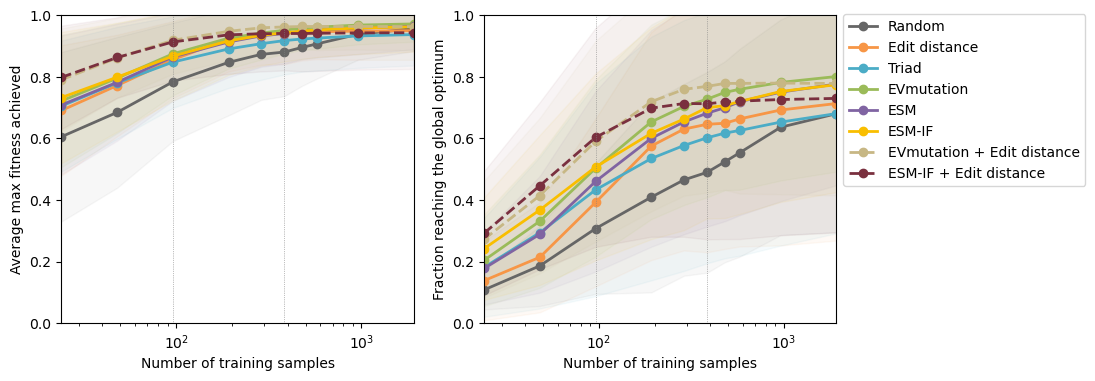

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = ["gray", "orange", "blue", "green", "purple", "yellow", "light_brown", "maroon"]
ls = ["solid"]*6 + ["dashed"]*2

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes", "if_truemaxs"],
    ["mean_all", "fraction_max"],
    ["Average max fitness achieved", "Fraction reaching the global optimum"],
):

    for i, mlde_opts in enumerate(['Random', 'ftMLDE: Edit distance', 'ftMLDE: Triad', 'ftMLDE: EVmutation', 'ftMLDE: ESM', 'ftMLDE: ESM-IF', 'EVmutation + Edit distance', 'ESM-IF + Edit distance']):

        mlde_df=avg_mlde_df_dict[mlde_opts]

        ax.plot(
            mlde_df["n_sample_"],
            mlde_df[f"{mlde_metric}_mean_mean"],
            label=mlde_opts.replace("ftMLDE: ", ""),
            marker="o",
            linestyle=ls[i],
            linewidth=2,
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
        )
        ax.fill_between(
            mlde_df["n_sample_"],
            mlde_df[f"{mlde_metric}_mean_mean"] - mlde_df[f"{mlde_metric}_mean_std"],
            mlde_df[f"{mlde_metric}_mean_mean"] + mlde_df[f"{mlde_metric}_mean_std"],
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
            alpha=0.05,
        )

    ax.axvline(
        96,
        linestyle="dotted",
        color="gray",
        linewidth=0.5
    )

    ax.axvline(
        384,
        linestyle="dotted",
        color="gray",
        linewidth=0.5
    )
    # for de in DE_TYPES:
    #     ax.axhline(
    #         de_avg.loc[de, f"{de_metric}_mean"],
    #         label=f"DE: {DE_LEGEND_MAP[de]}",
    #         color=DE_COLORS[de],
    #         linestyle="dashed",
    #         linewidth=2,
    #     )
    #     ax.fill_between(
    #         N_SAMPLE_LIST,
    #         de_avg.loc[de, f"{de_metric}_mean"] - de_avg.loc[de, f"{de_metric}_std"],
    #         de_avg.loc[de, f"{de_metric}_mean"] + de_avg.loc[de, f"{de_metric}_std"],
    #         color=DE_COLORS[de],
    #         alpha=0.03,
    #     )

    ax.set_xlim(N_SAMPLE_LIST[0], N_SAMPLE_LIST[-1])
    ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel(y_label)

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1.025))


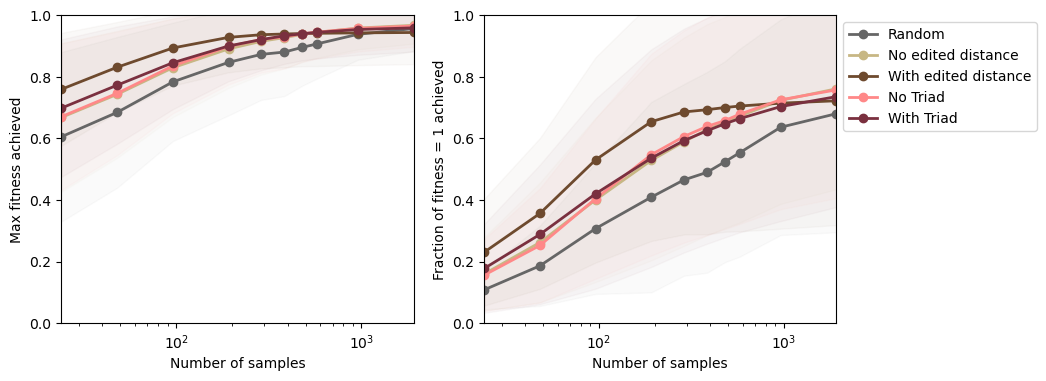

In [21]:
# sup

n_top=96

for et in all_slice_merge["Ensemble type"].unique():
    avg_mlde_df_dict[et]= avg_lib(all_slice_merge, N_SAMPLE_LIST, "Ensemble type", [et], active_lib_list)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = ["gray", "light_brown", "brown", "red", "maroon"]

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes", "if_truemaxs"],
    ["mean_all", "fraction_max"],
    ["Max fitness", "Fraction of fitness = 1"],
):

    for i, mlde_opts in enumerate(["Random"] + list(all_slice_merge["Ensemble type"].unique())):

        mlde_df = avg_mlde_df_dict[mlde_opts]

        ax.plot(
            mlde_df["n_sample_"],
            mlde_df[f"{mlde_metric}_mean_mean"],
            label=mlde_opts,
            marker="o",
            linestyle="solid",
            linewidth=2,
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
        )
        ax.fill_between(
            mlde_df["n_sample_"],
            mlde_df[f"{mlde_metric}_mean_mean"] - mlde_df[f"{mlde_metric}_mean_std"],
            mlde_df[f"{mlde_metric}_mean_mean"] + mlde_df[f"{mlde_metric}_mean_std"],
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
            alpha=0.03,
        )

    # for de in DE_TYPES:
    #     ax.axhline(
    #         de_avg.loc[de, f"{de_metric}_mean"],
    #         label=f"DE: {DE_LEGEND_MAP[de]}",
    #         color=DE_COLORS[de],
    #         linestyle="dashed",
    #         linewidth=2,
    #     )
    #     ax.fill_between(
    #         N_SAMPLE_LIST,
    #         de_avg.loc[de, f"{de_metric}_mean"] - de_avg.loc[de, f"{de_metric}_std"],
    #         de_avg.loc[de, f"{de_metric}_mean"] + de_avg.loc[de, f"{de_metric}_std"],
    #         color=DE_COLORS[de],
    #         alpha=0.03,
    #     )

    ax.set_xlim(N_SAMPLE_LIST[0], N_SAMPLE_LIST[-1])
    ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"{y_label} achieved")

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# fig.suptitle(
#     "(ft)MLDE Performance Across 10 Minimally Active Landscapes",
#     fontsize=12,
#     fontweight="bold",
#     y=0.95,
# )

Text(0.5, 0.95, '(ft)MLDE Performance Across 10 Minimally Active Landscapes')

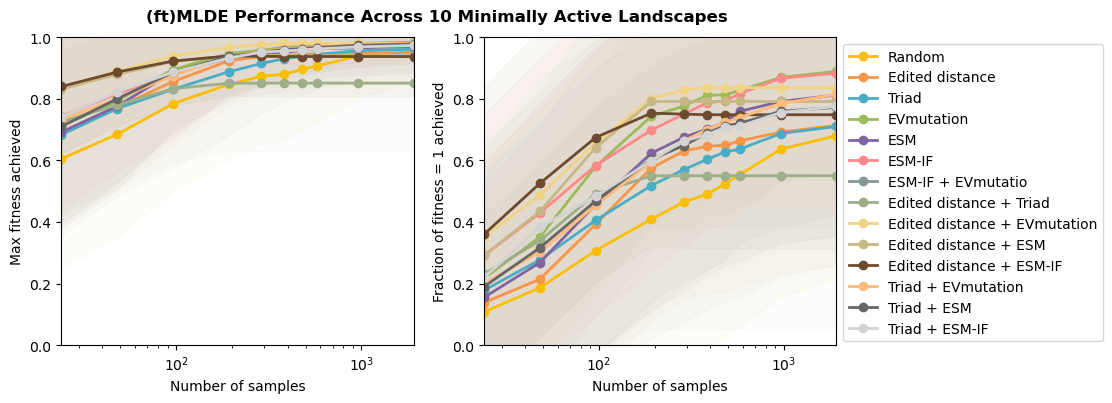

In [32]:
avg_mlde_df_dict = {
    "Random": get_mlde_avg_sdf(mlde_all, 96, "all", ["none"], active_lib_list),
    "Edited distance": get_mlde_avg_sdf(mlde_all, 96, "double", ["none"], active_lib_list),
    "Triad": get_mlde_avg_sdf(mlde_all, 96, "all", ["Triad_score"], active_lib_list),
    "EVmutation": get_mlde_avg_sdf(mlde_all, 96, "all", ["ev_score"], active_lib_list),
    "ESM": get_mlde_avg_sdf(mlde_all, 96, "all", ["esm_score"], active_lib_list),
    "ESM-IF": get_mlde_avg_sdf(mlde_all, 96, "all", ["esmif_score"], active_lib_list),
    "ESM-IF + EVmutatio": get_mlde_avg_sdf(mlde_all, 96, "all", ["two-best_score"], active_lib_list),
    "Edited distance + Triad": get_mlde_avg_sdf(mlde_all, 96, "double", ["Triad_score"], active_lib_list),
    "Edited distance + EVmutation": get_mlde_avg_sdf(mlde_all, 96, "double", ["ev_score"], active_lib_list),
    "Edited distance + ESM": get_mlde_avg_sdf(mlde_all, 96, "double", ["esm_score"], active_lib_list),
    "Edited distance + ESM-IF": get_mlde_avg_sdf(mlde_all, 96, "double", ["esmif_score"], active_lib_list),
    "Triad + EVmutation": get_mlde_avg_sdf(mlde_all, 96, "all", ["Triad-ev_score"], active_lib_list),
    "Triad + ESM": get_mlde_avg_sdf(mlde_all, 96, "all", ["Triad-esm_score"], active_lib_list),
    "Triad + ESM-IF": get_mlde_avg_sdf(mlde_all, 96, "all", ["struc-comb_score"], active_lib_list),
    # "Avg ftMLDE": ((get_mlde_avg_sdf(mlde_all, 96, "all", ZS_OPTS[1:], active_lib_list)*len(ZS_OPTS[1:]) + get_mlde_avg_sdf(mlde_all, 96, "double", ["none"], active_lib_list)))/(len(ZS_OPTS[1:])+1),
    # "Avg ftMLDE + Edited ditance": get_mlde_avg_sdf(mlde_all, 96, "double", ZS_OPTS[1:], active_lib_list),
    # "Avg ftMLDE + Triad": (get_mlde_avg_sdf(mlde_all, 96, "all", ["Triad-ev_score", "Triad-esm_score"], active_lib_list)*2 + get_mlde_avg_sdf(mlde_all, 96, "double", ["Triad_score"], active_lib_list))/3
}

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = ["yellow", "orange", "blue", "green", "purple", "red"]

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes", "if_truemaxs"],
    ["mean_all", "fraction_max"],
    ["Max fitness", "Fraction of fitness = 1"],
):

    for i, (mlde_opts, mlde_df) in enumerate(avg_mlde_df_dict.items()):

        ax.plot(
            mlde_df.index,
            mlde_df[f"{mlde_metric}_mean"],
            label=mlde_opts,
            marker="o",
            linestyle="solid",
            linewidth=2,
            color=more_colors[i],
        )
        ax.fill_between(
            mlde_df.index,
            mlde_df[f"{mlde_metric}_mean"] - mlde_df[f"{mlde_metric}_std"],
            mlde_df[f"{mlde_metric}_mean"] + mlde_df[f"{mlde_metric}_std"],
            color=more_colors[i],
            alpha=0.03,
        )

    # for de in DE_TYPES:
    #     ax.axhline(
    #         de_avg.loc[de, f"{de_metric}_mean"],
    #         label=f"DE: {DE_LEGEND_MAP[de]}",
    #         color=DE_COLORS[de],
    #         linestyle="dashed",
    #         linewidth=2,
    #     )
    #     ax.fill_between(
    #         N_SAMPLE_LIST,
    #         de_avg.loc[de, f"{de_metric}_mean"] - de_avg.loc[de, f"{de_metric}_std"],
    #         de_avg.loc[de, f"{de_metric}_mean"] + de_avg.loc[de, f"{de_metric}_std"],
    #         color=DE_COLORS[de],
    #         alpha=0.03,
    #     )

    ax.set_xlim(N_SAMPLE_LIST[0], N_SAMPLE_LIST[-1])
    ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"{y_label} achieved")

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

fig.suptitle(
    "(ft)MLDE Performance Across 10 Minimally Active Landscapes",
    fontsize=12,
    fontweight="bold",
    y=0.95,
)

In [42]:
merge_simplezs_df = pd.concat([ds_mlde_df, full_mlde_df]).rename(columns={"zs_": "zs", "lib_": "lib", "n_sample_": "n_sample"})
merge_simplezs_df

,zs,lib,n_sample,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
0,ed_score,DHFR,24,0.884260,0.071623,0.110000,0.314466,Edited distance
1,ed_score,DHFR,48,0.923741,0.065058,0.170000,0.377525,Edited distance
2,ed_score,DHFR,96,0.955333,0.059433,0.410000,0.494311,Edited distance
3,ed_score,DHFR,192,0.987020,0.032284,0.680000,0.468826,Edited distance
4,ed_score,DHFR,288,0.992195,0.024971,0.750000,0.435194,Edited distance
...,...,...,...,...,...,...,...,...
795,struc-comb_score,TrpB4,384,0.788251,0.116215,0.091667,0.288796,Triad +
796,struc-comb_score,TrpB4,480,0.786185,0.109811,0.063333,0.243968,Triad +
797,struc-comb_score,TrpB4,576,0.792464,0.112871,0.090000,0.286660,Triad +
798,struc-comb_score,TrpB4,960,0.800263,0.108684,0.083333,0.276847,Triad +


In [47]:
ens_merge_df

,zs,lib,n_sample,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble,color,Ensemble type,type
205,ESM-IF\nEdit distance,DHFR,384,0.997022,0.018989,0.943333,0.231591,Edited distance +,#f9be00,With edited distance,Enzymatic activity
215,ESM-IF\nEdit distance,GB1,384,0.665795,0.104128,0.046667,0.211276,Edited distance +,#f9be00,With edited distance,Binding
225,ESM-IF\nEdit distance,ParD2,384,1.000000,0.000000,1.000000,0.000000,Edited distance +,#f9be00,With edited distance,Binding
235,ESM-IF\nEdit distance,ParD3,384,0.980904,0.026671,0.173333,0.379168,Edited distance +,#f9be00,With edited distance,Binding
245,ESM-IF\nEdit distance,TrpB3D,384,0.999862,0.001373,0.990000,0.099665,Edited distance +,#f9be00,With edited distance,Enzymatic activity
255,ESM-IF\nEdit distance,TrpB3E,384,1.000000,0.000000,1.000000,0.000000,Edited distance +,#f9be00,With edited distance,Enzymatic activity
265,ESM-IF\nEdit distance,TrpB3F,384,1.000000,0.000000,1.000000,0.000000,Edited distance +,#f9be00,With edited distance,Enzymatic activity
275,ESM-IF\nEdit distance,TrpB3G,384,0.991770,0.041960,0.960000,0.196287,Edited distance +,#f9be00,With edited distance,Enzymatic activity
285,ESM-IF\nEdit distance,TrpB3I,384,0.999969,0.000532,0.996667,0.057735,Edited distance +,#f9be00,With edited distance,Enzymatic activity
295,ESM-IF\nEdit distance,TrpB4,384,0.769928,0.055546,0.013333,0.114889,Edited distance +,#f9be00,With edited distance,Enzymatic activity


Edit distance : t=-0.696 and p=0.547
Triad : t=0.127 and p=0.906
EVmutation : t=-0.413 and p=0.714
ESM : t=-0.502 and p=0.659
ESM-IF : t=-0.246 and p=0.822
ESM-IF
Edit distance : t=-0.736 and p=0.528
EVmutation
Edit distance : t=-0.642 and p=0.575
Edit distance : t=-1.278 and p=0.301


/tmp/ipykernel_4062117/1030879178.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90, ha="center")
/tmp/ipykernel_4062117/1030879178.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90, ha="center")
/tmp/ipykernel_4062117/1030879178.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90, ha="center")


Triad : t=-0.588 and p=0.596
EVmutation : t=-0.955 and p=0.419


/tmp/ipykernel_4062117/1030879178.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90, ha="center")
/tmp/ipykernel_4062117/1030879178.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90, ha="center")
/tmp/ipykernel_4062117/1030879178.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90, ha="center")


ESM : t=-1.091 and p=0.366
ESM-IF : t=-0.879 and p=0.446
ESM-IF
Edit distance : t=-1.325 and p=0.280


/tmp/ipykernel_4062117/1030879178.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90, ha="center")


EVmutation
Edit distance : t=-1.286 and p=0.296


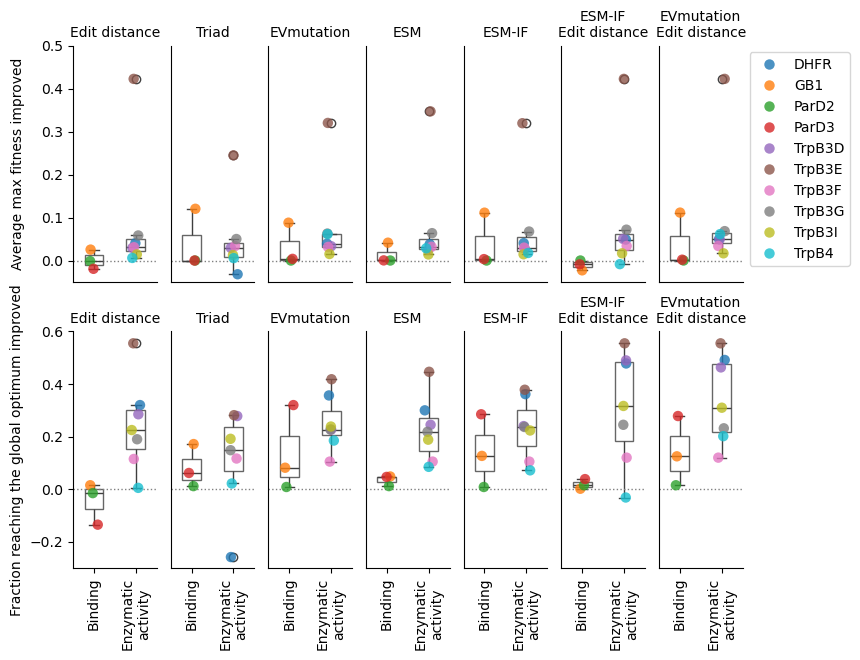

In [52]:
fig, axes = plt.subplots(2, 7, figsize=(8.4, 6.4))

n_top = 384
slice_df = merge_simplezs_df[(merge_simplezs_df["n_sample"]==n_top)&(merge_simplezs_df["zs"].isin(["none"] + ZS_OPTS))].copy()

# Convert 'Category' column to categorical with defined order
slice_df['zs'] = pd.Categorical(slice_df['zs'], categories=["none"] + ZS_OPTS, ordered=True)
slice_df = slice_df.sort_values(by=['zs', "lib"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["lib"].map(lambda x: LIB_INFO_DICT[x]["type"])

ens_df = all_slice_merge[all_slice_merge["n_sample"] == n_top].sort_values(by=["lib"]).copy()
ens_merge_df = pd.concat(
    [
        ens_df[
            (ens_df["zs"] == "esmif_score")
            & (ens_df["Ensemble type"] == "With edited distance")
        ],
        ens_df[
            (ens_df["zs"] == "ev_score")
            & (ens_df["Ensemble type"] == "With edited distance")
        ],
    ],
)
ens_merge_df["zs"] = ens_merge_df["zs"].map(
    {
        "esmif_score": "ESM-IF\nEdit distance",
        "ev_score": "EVmutation\nEdit distance",
        # **ZS_OPTS_LEGEND,
    }
)
ens_merge_df["type"] = ens_merge_df["lib"].map(lambda x: LIB_INFO_DICT[x]["type"])


ms = ["top_maxes_mean", "if_truemaxs_mean"]
ms_dict = {'top_maxes_mean': "Average max fitness improved", "if_truemaxs_mean": "Fraction reaching the global optimum improved"}


for i in range(len(ms)):
    x = ms[i]
    rand_df = slice_df[slice_df["zs"]=="Random"][["lib", "type", x]].reset_index(drop=True).copy()

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:]) + list(ens_merge_df["zs"].unique())):
        ax = axes[i, z]
        if z<5:
            bar_type_df = slice_df[slice_df["zs"] == zs][["lib", "type", x]].reset_index(drop=True).copy()
        else:
            bar_type_df = ens_merge_df[ens_merge_df["zs"] == zs][["lib", "type", x]].reset_index(drop=True).copy()
        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["lib", "type"])
        merg_df["delta"] = merg_df[x+"_x"] - merg_df[x+"_y"]

        sns.boxplot(
            # x="Type", y="Rho", 
            x="type", y="delta", 
            data=merg_df, 
            width=0.45, 
            ax=ax,
            order=["Binding", "Enzymatic activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzymatic activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="lib",
            hue_order=merg_df['lib'].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=sns.color_palette("tab10").as_hex(),
            marker="o",
            alpha=0.8,
            ax=ax
        )

        labels = [label.get_text().replace('Enzymatic activity', 'Enzymatic\nactivity') for label in ax.get_xticklabels()]
        
        if i == 0:
            ymax = 0.5
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.05, ymax)
        else:
            ymax = 0.6
            ax.set_xlabel("")
            ax.set_ylim(-0.3, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))
        
        if z==0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks



        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        ax.legend().remove()
        ax.set_title(zs,fontdict={
            'fontsize': 10,
        })
            
        # # Hide the top and right spine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.axhline(0, color='gray', lw=1, ls="dotted")
        
        # if z != len(ZS_OPTS)-1:
        #     ax.legend().remove()
        # else:
        #     ax.legend(loc="upper left", bbox_to_anchor=(1, 1.0))
        # if z == 0:
        #     ax.set_ylabel(r"Spearman's $\rho$")
        # else:
        #     ax.set_ylabel("")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"]=="Binding"][x]),
            list(bar_type_df[bar_type_df["type"]=="Enzymatic activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p+q)*.5, annot_y, "*", ha='center', va='bottom', color='gray')

axes[0,6].legend(loc="upper left", bbox_to_anchor=(1, 1.0))
plt.tight_layout(pad=0, h_pad=1.0, w_pad=1.0)